<a href="https://www.kaggle.com/code/galaxyarchitects/architects-multi-class-classification-ann-tf?scriptVersionId=140419847" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 0. Model Description
### Build a simple feed-forward deep NN that could predict architects' names based on their designs. The model could be enhanced by using CNNs or architectures like LeNet, AlexNet, VGG, ResNet... and of course by building a great dataset of different architects' designs.
### Dataset: https://www.kaggle.com/datasets/galaxyarchitects/architects-dataset

# 1. Import Libraries

In [1]:
import os
import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### 1.1 Switch to TensorFlow GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limit GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  0


### 2. Loading Dataset

In [3]:
dataset = "/kaggle/input/architects-dataset"

In [4]:
def listdirs(dataset):
    subfolders = []
    for file in os.listdir(dataset):
        d = os.path.join(dataset, file)
        if os.path.isdir(d):
            subfolders.append(d) #(d.replace("\\", "/"))
            subfolders.extend(listdirs(d))
    return subfolders

subfolders_list = listdirs(dataset)
#remove = str.maketrans('', '', "[]'")
#subfolders_list = subfolders_list.translate(remove)
print(subfolders_list)

['/kaggle/input/architects-dataset/Bjarke Ingels', '/kaggle/input/architects-dataset/Alvaro Siza', '/kaggle/input/architects-dataset/Richard Meier', '/kaggle/input/architects-dataset/Michael Graves', '/kaggle/input/architects-dataset/Le Corbusier', '/kaggle/input/architects-dataset/Frank Gehry', '/kaggle/input/architects-dataset/Eero Saarinen', '/kaggle/input/architects-dataset/Norman Foster', '/kaggle/input/architects-dataset/Oscar Niemeyer', '/kaggle/input/architects-dataset/Renzo Piano', '/kaggle/input/architects-dataset/Bernard Tschumi', '/kaggle/input/architects-dataset/Kenzo Tange', '/kaggle/input/architects-dataset/Tadao Ando', '/kaggle/input/architects-dataset/Antonio Gaudi', '/kaggle/input/architects-dataset/Philip Johnson', '/kaggle/input/architects-dataset/Rem Koolhaas', '/kaggle/input/architects-dataset/Daniel Libeskind', '/kaggle/input/architects-dataset/Toyo Ito', '/kaggle/input/architects-dataset/Jean Nouvel', '/kaggle/input/architects-dataset/Mies van der Rohe', '/kaggl

# 3. Generating Dataset

In [5]:
img_height = 180
img_width = 180
batch_size = 32

#tf.data.Dataset??
data = tf.keras.utils.image_dataset_from_directory(dataset, batch_size=batch_size, image_size = (img_height, img_width))

Found 2199 files belonging to 25 classes.


In [6]:
data_iterator = data.as_numpy_iterator()

In [7]:
#Get another batch from the iterator
batch = data_iterator.next()

#Images represented as numpy arrays
batch[0].shape

(32, 180, 180, 3)

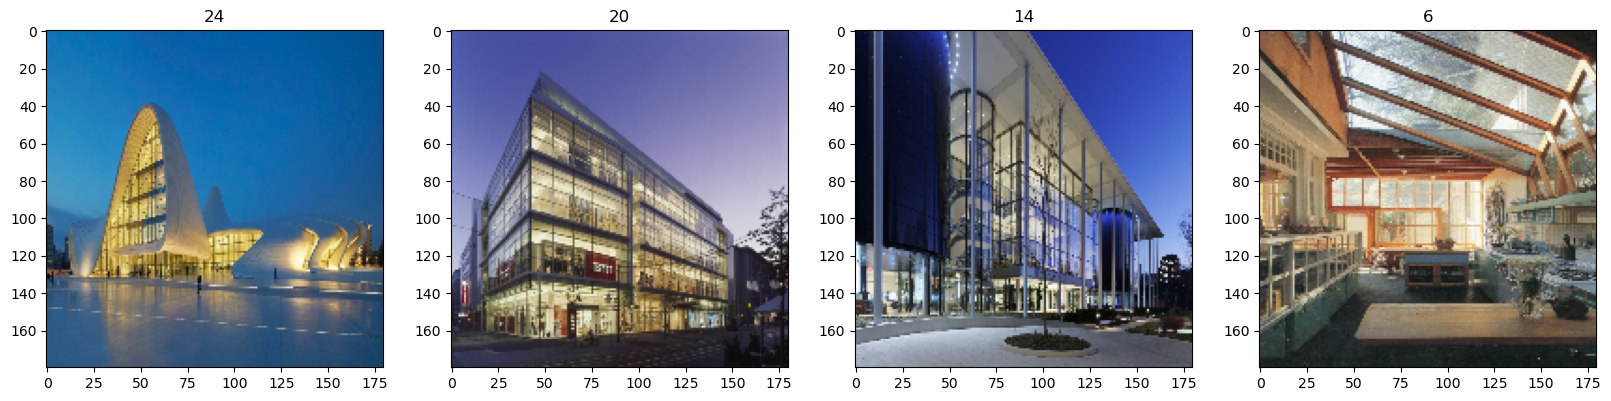

In [8]:
# plot data from a batch
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Preprocessing Data

### 4.1. Scaling Data

In [9]:
data = data.map(lambda x,y: (x/255.0, y))
data.as_numpy_iterator().next()[0].max()

1.0

### 4.2. One-Hot-Encoding

In [10]:
all_labels = []
for images, labels in data:
    all_labels.append(labels)

all_labels = tf.concat(all_labels, axis=0)

num_classes = tf.reduce_max(all_labels) + 1

def one_hot_encode(labels, num_classes):
    return tf.one_hot(labels, num_classes)

one_hot_encoded_labels = one_hot_encode(all_labels, num_classes)

label_dataset = tf.data.Dataset.from_tensor_slices(one_hot_encoded_labels)

full_dataset = tf.data.Dataset.zip((data, label_dataset))

In [11]:
# Apply the split function to the zipped dataset
image_dataset = full_dataset.map(lambda x, y: x)
label_dataset = full_dataset.map(lambda x, y: y)

### 4.3. Splitting Data

In [12]:
len(image_dataset) #number of batches

train_size = int(len(image_dataset)*0.7)
val_size = int(len(image_dataset)*0.2)
test_size = int(len(image_dataset)*0.1)

train_size+val_size+test_size

train = image_dataset.take(train_size)
val = image_dataset.skip(train_size).take(val_size)
test = image_dataset.skip(train_size+val_size).take(test_size)

len(test)

6

# 5. Deep Learning Model (FeedForward Neural Network)

In [13]:
model = Sequential()

model.add(Dense(10, input_shape=(img_height,img_width,3), activation = 'relu'))

model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))

model.add(Flatten())

model.add(Dense(25, activation = 'softmax'))

In [14]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 180, 180, 10)      40        
                                                                 
 dense_1 (Dense)             (None, 180, 180, 10)      110       
                                                                 
 dense_2 (Dense)             (None, 180, 180, 10)      110       
                                                                 
 dense_3 (Dense)             (None, 180, 180, 10)      110       
                                                                 
 flatten (Flatten)           (None, 324000)            0         
                                                                 
 dense_4 (Dense)             (None, 25)                8100025   
                                                                 
Total params: 8,100,395
Trainable params: 8,100,395
Non-

# 6. Train the Model

In [16]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [17]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
48/48 [==============================] - 51s 981ms/step - loss: 8.2429 - accuracy: 0.1029 - val_loss: 3.0251 - val_accuracy: 0.1611
Epoch 2/20
48/48 [==============================] - 49s 993ms/step - loss: 2.7401 - accuracy: 0.1895 - val_loss: 2.6526 - val_accuracy: 0.2885
Epoch 3/20
48/48 [==============================] - 49s 988ms/step - loss: 2.2209 - accuracy: 0.3874 - val_loss: 2.2079 - val_accuracy: 0.4014
Epoch 4/20
48/48 [==============================] - 51s 1s/step - loss: 1.3930 - accuracy: 0.6341 - val_loss: 1.6249 - val_accuracy: 0.5601
Epoch 5/20
48/48 [==============================] - 52s 1s/step - loss: 0.7486 - accuracy: 0.8092 - val_loss: 1.2475 - val_accuracy: 0.7260
Epoch 6/20
48/48 [==============================] - 51s 1s/step - loss: 0.4232 - accuracy: 0.9023 - val_loss: 1.1712 - val_accuracy: 0.7500
Epoch 7/20
48/48 [==============================] - 51s 1s/step - loss: 0.2206 - accuracy: 0.9505 - val_loss: 0.7809 - val_accuracy: 0.8510
Epoch 8/20


### 6.1. Plot the Model's Performance

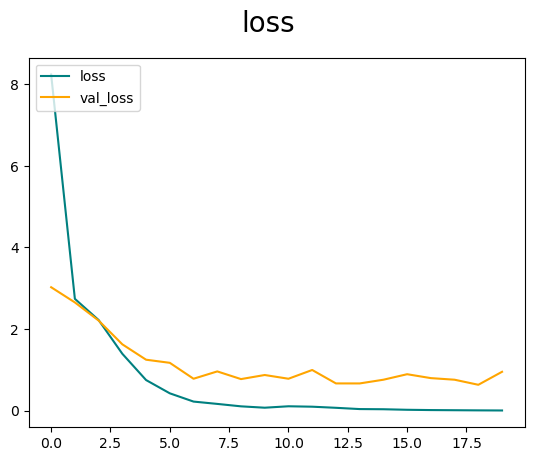

In [18]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 7. Testing the Model

In [19]:
classes_list = ["Alvaro Siza", "Antonio Gaudi", "Bernard Tschumi", "Bjarke Ingels", "Daniel Libeskind", 
               "Eero Saarinen", "Frank Gehry", "Gordon Bunshaft", "I M Pei", "Jean Nouvel", 
               "Kenzo Tange", "Le Corbusier", "Michael Graves", "Mies van der Rohe", "Norman Foster", 
               "Oscar Niemeyer", "Peter Eisenman", "Philip Johnson", "Rem Koolhaas", "Renzo Piano", 
               "Richard Meier", "Santiago Calatrava", "Tadao Ando", "Toyo Ito", "Zaha Hadid"]

img = keras.utils.load_img(
    "/kaggle/input/architects-dataset/Alvaro Siza/1 (5).jpg", target_size=(img_height, img_width)
)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
img_array /= 255.0 

predictions = model.predict(img_array)
#predicted_class_index = tf.argmax(predictions, axis=-1)

for class_name, prob in zip(classes_list, predictions[0]):
    print(f"{class_name}: {prob}")

predicted_class_index = tf.math.argmax(predictions[0], axis=-1)

predicted_class = classes_list[predicted_class_index]

confidence_percentage = 100 * predictions[0][predicted_class_index]

print(f"This image is classified as {predicted_class} with confidence {confidence_percentage:.2f}%.")

1/1 [==============================] - 0s 242ms/step
Alvaro Siza: 0.9999994039535522
Antonio Gaudi: 5.4780384672881155e-09
Bernard Tschumi: 3.784928533784315e-12
Bjarke Ingels: 4.695704380885957e-10
Daniel Libeskind: 1.3432783774192103e-09
Eero Saarinen: 5.0011152852432947e-14
Frank Gehry: 8.744276136507523e-11
Gordon Bunshaft: 3.368606282805331e-09
I M Pei: 3.1426444884857232e-15
Jean Nouvel: 1.572658625548229e-08
Kenzo Tange: 7.619271968906105e-08
Le Corbusier: 5.187766327630072e-10
Michael Graves: 3.3598457349626187e-10
Mies van der Rohe: 2.597989809665236e-15
Norman Foster: 3.9904007181901235e-11
Oscar Niemeyer: 2.553953576400758e-11
Peter Eisenman: 7.398581747253274e-12
Philip Johnson: 1.118590138050879e-12
Rem Koolhaas: 1.462523990802822e-09
Renzo Piano: 2.1880796328456464e-13
Richard Meier: 2.914588321800693e-07
Santiago Calatrava: 1.8345335206504387e-07
Tadao Ando: 2.0514634844928485e-14
Toyo Ito: 2.2182650383228975e-08
Zaha Hadid: 1.5180638968104176e-08
This image is classifie

# 8. Saving the Model

In [20]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models', 'architects.h5'))

# 9. Loading the Model

In [21]:
new_model = load_model(os.path.join('models', 'architects.h5'))